# Lab: SVMs on Extended MNIST

In the [MNIST demo](../Demos/demo_mnist_svm.ipynb), we saw how SVMs can be used for the classic MNIST problem of digit recognition. In this lab, we are going to extend the MNIST dataset by adding a number of non-digit letters and see if the classifier can distinguish the digits from the non-digits. All non-digits will be lumped as a single 11-th class. This is a highly simplified version of a 'detection' problem (as opposed to 'classification' problem). Detection is vital in OCR and related problems since the non useful characters must be rejected. 

In addition to the concepts in the demo, you will learn:
* Combine multiple datasets
* Select the SVM parameters (`C` and `gamma`) via cross-validation.
* Use the `GridSearchCV` method to search for parameters with cross-validation.


As usual, we download the standard packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

## Downloading the EMNIST Dataset

After creating the highly popular MNIST dataset, NIST created an extended version of the dataset that includes letters and digits.
The extended datbase (called EMNIST) also has many more examples per class.  

To download the data, go to the [EMNIST webpage](https://www.nist.gov/itl/iad/image-group/emnist-dataset).  Near the bottom, you will see a link for `MATLAB format dataset`.  If you click on this link, you will download a `zip` file with several datasets in it.  The total file is 726M, so it may take some time and diskspace to download.  Extract two files:
* `emnist-digits.mat`:  This is a file of digits `0` to `9`, but with more examples per class.
* `emnist-letters.mat`:  This is a file of letters `a/A` to `z/Z`.  The lower and upper case letters are grouped into the same class.

Once you get these two files, you can save yourself the diskspace and remove all the other files.

In [2]:
# TODO:  Download emnist-letters.mat and emnist-digits.mat to the working directory

Since MATLAB files are still widely-used, Python has excellent routines for loading MATLAB files.  The function below uses the `scipy.io` package to extract the relevant fields from the MATLAB file.  Specifically, the function extracts the training and test data from MATLAB file. 

In [3]:
import scipy.io
def load_emnist(file_path='emnist-digits.mat'):
    """
    Loads training and test data with ntr and nts training and test samples
    The `file_path` is the location of the `eminst-balanced.mat`.
    """    
    
    # Load the MATLAB file
    mat = scipy.io.loadmat(file_path)
    
    # Get the training data
    Xtr = mat['dataset'][0][0][0][0][0][0][:]
    ntr = Xtr.shape[0]
    ytr = mat['dataset'][0][0][0][0][0][1][:].reshape(ntr).astype(int)
    
    # Get the test data
    Xts = mat['dataset'][0][0][1][0][0][0][:]
    nts = Xts.shape[0]
    yts = mat['dataset'][0][0][1][0][0][1][:].reshape(nts).astype(int)
    
    print("%d training samples, %d test samples loaded" % (ntr, nts))

    return [Xtr, Xts, ytr, yts]

Use the function above to get all the digit images from the `emnist-digits.mat` file.  

In [4]:
# TODO:  Load the digit data from emnist-digits.mat
# Xtr_dig, Xts_dig, ytr_dig, yts_dig = ...
Xtr_dig, Xts_dig, ytr_dig, yts_dig = load_emnist(file_path='emnist-digits.mat')

240000 training samples, 40000 test samples loaded


You should see 240000 training samples and 40000 test samples.  Now use the same function to get the letter characters from `emnist-letters.mat`.  

In [5]:
# TODO:  Load the digit data from emnist-letters.mat
# Xtr_let, Xts_let, ytr_let, yts_let = ...
Xtr_let, Xts_let, ytr_let, yts_let = load_emnist(file_path='emnist-letters.mat')

124800 training samples, 20800 test samples loaded


You should see 124800 training samples and 20800 test samples.  Next, will recreate the `plt_digit` function from the demo.

In [6]:
def plt_digit(x,y=None):
    nrow = 28
    ncol = 28
    xsq = x.reshape((nrow,ncol))
    plt.imshow(xsq.T,  cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])    
    if y != None:
        plt.title('%d' % y)        

Plot 8 random samples from the digit training data.  You can use the `plt_digit` function above with `subplot` to create a nice display.  I suggest sizing your plots using the `plt.figure(figsize=(10,20))` command.

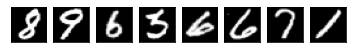

In [7]:
# TODO:  Plot 8 random samples from the training data of the digits
nplt = 8
nsamp = Xtr_dig.shape[0]
Iperm = np.random.permutation(nsamp)

for i in range(nplt):
    ind = Iperm[i]
    plt.subplot(1,nplt,i+1)
    plt_digit(Xtr_dig[i,:])

Next, plot 8 random samples from the letters training data.  You should see that the labels go from 0 to 25, corresponding to `a` to `z`.  Upper and lower case letters belong to the same class.

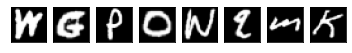

In [8]:
# TODO:  Plot 8 random samples from the training data of the letters
nplt = 8
nsamp = Xtr_let.shape[0]
Iperm = np.random.permutation(nsamp)

for i in range(nplt):
    ind = Iperm[i]
    plt.subplot(1,nplt,i+1)
    plt_digit(Xtr_let[i,:])

## Creating a Non-Digit Class

SVM classifiers are very slow to train.  The training is particularly slow when there are a large number of classes.  To speed things up, we are going to put all of the letters in one class and merge that class with the digits data.  

Before we begin, we will remove all the samples corresponding to `i/I`, `l/L` and `o/O`, since otherwise these letters would get confused with the digits `0` and `1`.  Create arrays `Xtr_let_rem` and `ytr_let_rem` from the data `Xtr_let` and `ytr_let`, where the samples `i` with `ytr_let[i] == 9, 12, 15` are removed.   Create `Xts_let_rem` and `yts_let_rem` similarly.

If you are clever, you can do this without a for-loop via python broadcasting and `np.all(..., axis=1)` command.  But, if you like, you can use a for-loop.

In [9]:
remove_list = np.array([9,12,15])
index_list_tr = []
index_list_ts = []
for i in range(ytr_let.shape[0]):
    if ytr_let[i] in remove_list:
        index_list_tr.append(i)
    else:
        continue
index_list_tr = np.array(index_list_tr)
for i in range(yts_let.shape[0]):
    if yts_let[i] in remove_list:
        index_list_ts.append(i)
    else:
        continue
index_list_ts = np.array(index_list_ts)
# TODO:  Create arrays with labels 9, 12 and 15 removed
# Xtr_let_rem, ytr_let_rem = ...
Xtr_let_rem = np.delete(Xtr_let,index_list_tr,0)
ytr_let_rem = np.delete(ytr_let,index_list_tr,0)
# Xts_let_rem, yts_let_rem = ...
Xts_let_rem = np.delete(Xts_let,index_list_ts,0)
yts_let_rem = np.delete(yts_let,index_list_ts,0)

To speed things up even further, we will use only a small subset of the training and test data.  Of course, we will not get great results with this small dataset.  But we can still illustrate the basic concepts.  

Create training arrays `Xtr1_dig` and `ytr1_dig` by selecting 5000 random samples from `Xtr_dig` and `ytr_dig`.  Then create training arrays `Xtr1_let` and `ytr1_let` by selecting 1000 random samples from `Xtr_let_rem` and `ytr_let_rem`.  Similarly, create test arrays `Xts1_dig,Xts1_let,yts1_dig,yts1_let` with 5000 digits and 1000 letters.

In [10]:
# Number of training and test digits and letters
ntr_dig = 5000
ntr_let = 1000
nts_dig = 5000
nts_let = 1000
index_dig_tr = np.random.choice(Xtr_dig.shape[0],ntr_dig,replace=False)
index_dig_ts = np.random.choice(Xts_dig.shape[0],nts_dig,replace=False)
index_let_tr = np.random.choice(Xtr_let_rem.shape[0],ntr_let,replace=False)
index_let_ts = np.random.choice(Xts_let_rem.shape[0],nts_let,replace=False)
# TODO Create sub-sampled training and test data
# Xtr1_dig, ytr1_dig = ...
Xtr1_dig = Xtr_dig[index_dig_tr]
ytr1_dig = ytr_dig[index_dig_tr]
# Xts1_dig, yts1_dig = ...
Xts1_dig = Xts_dig[index_dig_ts]
yts1_dig = yts_dig[index_dig_ts]
# Xtr1_let, ytr1_let = ...
Xtr1_let = Xtr_let_rem[index_let_tr]
ytr1_let = ytr_let_rem[index_let_tr]
# Xts1_let, yts1_let = ... 
Xts1_let = Xts_let_rem[index_let_ts]
yts1_let = yts_let_rem[index_let_ts]

Now we will merge our digit and letter training arrays.
* Create an array `Xtr` by stacking `Xtr1_dig`, `Xtr1_let`.  This should result in 6000 total samples.
* Create a new label vector `ytr` where `ytr[i] = ytr1_dig[i]` for any digit sample and `ytr[i]=10` for any letter sample.  Thus, all the letters are lumped into the single class with label 10.

Create test arrays `Xts` and `yts` similarly. 

You may wish to use the `np.hstack` and `np.vstack` methods.

In [11]:
# TODO:  Create combined letter and digit training and test data
# Xtr, ytr = ..
Xtr = np.vstack((Xtr1_dig,Xtr1_let))
ytr = np.zeros(6000)
ytr[:5000] = ytr1_dig
ytr[5000:] = 10*np.ones(1000)
# Xts, yts = ...
Xts = np.vstack((Xts1_dig,Xts1_let))
yts = np.zeros(6000)
yts[:5000] = yts1_dig
yts[5000:] = 10*np.ones(1000)

The features above use pixel values from 0 to 255.  Let's rescale the pixels to the interval from -1 to 1.  This will yield slightly better performance.  We'll put the scaled data into arrays `Xtr1` and `Xts1`.

In [12]:
# TODO:  Rescale the data to the interval from -1 to 1
# Xtr1 = ...
Xtr1 = Xtr/255.0*2-1
# Xts1 = ...
Xts1 = Xts/255.0*2-1

## The SVM classifier

Let's first create an SVM classifer with penalty `C=2.8` and an `rbf` kernel of width `gamma=.0073`. We will reexamine these choices later.

In [13]:
from sklearn import svm

# TODO:  Create a classifier: a support vector classifier
# svc = ...
svc = svm.SVC(probability=False, C=2.8, kernel='rbf', gamma=.0073,verbose=1)

Fit the classifier using the scaled training data.  Although SVMs are slow to train, we have kept the training set small, so the fitting should take less than a minute.

In [14]:
# TODO:  Fit the classifier on the training data. 
svc.fit(Xtr1,ytr)

[LibSVM]

SVC(C=2.8, gamma=0.0073, verbose=1)

Now let's compute and print the accuracy on the test data.  This too should take less than a minute.  You should get an accuracy of around 89%.

In [15]:
# TODO:  Measure error on the test data
yhat_ts = svc.predict(Xts1)
acc = np.mean(yhat_ts==yts)
print('Accuracy = {0:f}'.format(acc))

Accuracy = 0.914500


The error rate is bit higher than what we would get with digits only.  This is because the "letters" class is extremely complex.  

To see this, print and then plot the normalized confusion matrix.  You should see that the error rate on the "letters" class is much higher than the others.

[ 492  463  460  488  523  466  485  523  459  501 1140]
[0.98028496 0.99333905 0.97249598 0.99784255 0.97553589 0.96422564
 0.98338171 0.99657401 0.99087414 0.98086563 1.33698319]
[[0.959 0.    0.    0.    0.002 0.    0.    0.    0.    0.    0.045]
 [0.    0.987 0.004 0.    0.    0.002 0.    0.002 0.002 0.002 0.037]
 [0.    0.    0.943 0.    0.    0.    0.    0.004 0.004 0.    0.111]
 [0.002 0.    0.004 0.959 0.    0.004 0.    0.002 0.004 0.002 0.037]
 [0.    0.002 0.    0.    0.945 0.    0.002 0.    0.    0.015 0.08 ]
 [0.    0.    0.    0.019 0.    0.918 0.    0.    0.002 0.    0.082]
 [0.002 0.    0.    0.    0.    0.002 0.967 0.    0.    0.    0.054]
 [0.002 0.    0.    0.    0.002 0.    0.    0.964 0.002 0.017 0.025]
 [0.    0.    0.002 0.011 0.    0.011 0.002 0.    0.963 0.013 0.087]
 [0.    0.    0.    0.006 0.006 0.002 0.    0.02  0.008 0.916 0.026]
 [0.015 0.004 0.018 0.003 0.021 0.025 0.012 0.004 0.005 0.015 0.754]]


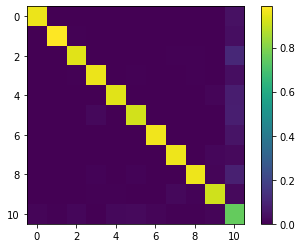

In [16]:
# TODO:  Print and plot the normalized confusion matrix
from sklearn.metrics import confusion_matrix
C = confusion_matrix(yts,yhat_ts)

# Normalize the confusion matrix
Csum = np.sum(C,0)
print(Csum)
C = C / Csum[:,None]
print(np.sum(C,0))

# Print the confusion matrix
print(np.array_str(C, precision=3, suppress_small=True))
plt.imshow(C, interpolation='none')
plt.colorbar()

Print the following:
* the fraction of digits that are mislabeled as letters  
* the fraction of letters that are mislabeled as digits

In [17]:
# TODO:  Print the above error rates
print("The fraction of digits that are mislabeled as letters: {}".format(np.mean(yhat_ts[:5000]==10)))
print("The fraction of letters that are mislabeled as digits: {}".format(np.mean(yhat_ts[5000:]!=10)))

The fraction of digits that are mislabeled as letters: 0.056
The fraction of letters that are mislabeled as digits: 0.14


## Optimizing gamma and C via Cross-Validation (Using For-Loops)

Above, and in the demo, we used externally provided `gamma` and `C` values.  In general, these parameters should be carefully chosen.  We will now choose these parameters via cross validation.

Below, we will try the value of `C` and `gamma` specified in the arrays `C_test` and `gam_test`.  For each combination of `C` and `gamma`, we fit the model on the training data and measure its accuracy on the test data.  Then we will select the `(C,gamma)` pair that results in the best accuracy.   

Ideally, we would try many more values for each of the parameters, but this would take a long time.  So, we will try only 3 values for each.  Still, this will take several minutes to complete. 

For this lab, you may do the parameter search over `C` and `gamma` in one of two ways:
* This section:  Use for-loops and manually search over the parameters.  This is more direct, and you can see and control exactly what is happening.
* Next section:  Use the `GridSearchCV` method in the `sklearn` package.  This takes a little reading, but once you learn this method, it is more efficient to program.

**You only need to submit the solution to one of the two sections.**  Pick whichever one you want.

In [18]:
C_test = [0.1,1,10]
gam_test = [0.001,0.01,0.1]

nC = len(C_test)
ngam = len(gam_test)
acc = np.zeros((nC,ngam))

# TODO:  Measure and print the accuracy for each C and gamma value.  Store the results in acc
for i in range(3):
    for j in range(3):
        svc = svm.SVC(probability=False, C=C_test[i], kernel='rbf', gamma=gam_test[j],verbose=1)
        svc.fit(Xtr1,ytr)
        yhat_ts = svc.predict(Xts1)
        accuracy = np.mean(yhat_ts==yts)
        acc[i,j] = accuracy

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [19]:
# TODO:  Print the accuracy matrix
print('The accuracy matrix:\n{}'.format(acc))

The accuracy matrix:
[[0.79283333 0.596      0.16666667]
 [0.87083333 0.8925     0.213     ]
 [0.90016667 0.9        0.21683333]]


In [20]:
# TODO:  Print the maximum accuracy and the corresponding best C and gamma
print('The maxinum accuracy: {}'.format(np.max(acc)))
print('The best C is: {}'.format(C_test[np.where(acc==np.max(acc))[0][0]]))
print('The best gamma is: {}'.format(gam_test[np.where(acc==np.max(acc))[1][0]]))

The maxinum accuracy: 0.9001666666666667
The best C is: 10
The best gamma is: 0.001


## Optimizing gamma and C via Cross-Validation (Using `GridSearchCV`)

As discussed above, we could implement cross-validation of `C` and `gamma` using for-loops.  But `sklearn` has an excellent method called `GridSearchCV` that automates this process.  In this lab, both for-loops and `GridSearchCV` are pretty easy to implement.  But, for complex parameter searches, `GridSearchCV` becomes much easier.  For example, `GridSearchCV` supports parallelization, so that different parameters can be tested simultaneously.  Below, we will implement cross-validation using `GridSearchCV`.  

**You do not have to do this section, if you did the previous section**.  

The `GridSearchCV` method does a train-test split in addition to the parameter search.  In this case, we already have a train-test split, and so we will first combine the train and test data back into a single dataset to use with `GridSearchCV`.

Create arrays `X` and `y` from `Xtr1`, `Xts1`, `ytr` and `yts`.  Use `np.vstack` and `np.hstack`.

In [21]:
# TODO:  Create combined trained and test data X and y.
# X = ...
# y = ...

Normally, `GridSearchCV` will do $K$-fold validation and automatically split the data into training and test in each fold.  But, in this case, we want it to perform only one fold with a specific train-test split.  To do this, we need to do the following:
* Create a vector `test_fold` where `test_fold[i] = -1` for the samples `i` in the training data (this indicates that they should not be used as test data in any fold) and `test_fold[i] = 0` for the samples `i` in the test data (this indicates that they should be as test data in fold 0).
* Call the method  `ps = sklearn.model_selection.PredefinedSplit(test_fold)` to create a predefined test split object.

In [22]:
# TODO:  Create a pre-defined test split object 
# import sklearn.model_selection
# test_fold = ...
# ps = sklearn.model_selection.PredefinedSplit(test_fold)

Next, read about the `GridSearchCV` method to set up a classifier that includes searching over the parameter grid.  
* For the `param_grid` parameter, you will want to create a dictionary to search over `C` and `gamma`.  You will also need to select the `kernel` parameter.
* Set `cv = ps` to use the fixed train-test split.
* Set `verbose=10` to monitor the progress

In [23]:
# TODO:  Create a GridSearchCV classifier
# clf = ...

Fit the classifier using the `fit` method.  The fit method will now search over all the parameters. This will take about 30 minutes.

In [24]:
# TODO: Fit the classifier

Print the `best_score_` and `best_params_` attributes of the classifier to find the best score and parameters

In [25]:
# TODO:  Print the best parameter and score of the classifier

Finally, you can print the test and train score from the `cv_results_['mean_test_score']` and `cv_results_['mean_train_score']`.

In [26]:
# TODO:  Print the mean test score for each parameter value.